# Lab 04 - ELE-32

## Alexandre Bellargus e Pedro Igor

### Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Classes Auxiliares

In [2]:
class VNode:
    def __init__(self, index):
        self.index = index
        self.edges = []
        self.value = 0
        self.errors = 0

class CNode:
    def __init__(self, index):
        self.index = index
        self.edges = []
        self.value = 0
    
class Edge:
    def __init__(self, cnode, vnode):
        self.cnode = cnode
        self.vnode = vnode
        self.val = 0

### Canal BSC

In [ ]:
class CanalBSC:
    def __init__(self, prob):
        self.prob = prob

    def canal(self, x):
        for i in range(len(x)):
            if self.prob > np.random.rand():
                if x[i] == 0:
                    x[i] = 1
                else:
                    x[i] = 0
        return x

### Canal Gaussiano

In [ ]:
class CanalGauss:
    def __init__(self, eb_n0):
        self.sigma2 = 1/(2*eb_n0)
        self.max_iter = 10
    
    def canal(self, v):
        r = []
        for i in range(len(v)):
            if(v[i] == 0):
                v[i] = 1
            else:
                v[i] = -1
            r.append(v[i] + np.random.normal(0, np.sqrt(self.sigma2)))            
        return r
    
    def LLR(self, r):
        L = []
        for i in range(len(r)):
            L.append(2*r[i]/self.sigma2)
        return L

### Hammimg

In [3]:
class Hamming:
    def __init__(self):
        self.G =[[1, 0, 0, 0, 1, 1, 1],
                 [0, 1, 0, 0, 1, 0, 1],
                 [0, 0, 1, 0, 1, 1, 0],
                 [0, 0, 0, 1, 0, 1, 1]]
        self.HT = [[1,1,1],
                   [1,0,1],
                   [1,1,0],
                   [0,1,1],
                   [1,0,0],
                   [0,1,0],
                   [0,0,1]]

    def codify(self, u):
        val = np.matmul(u, self.G)
        for i in range(len(val)):
            if val[i] % 2 == 0:
                val[i] = 0
            else:
                val[i] = 1
        return val
    
    def decodify(self, r):
        self.s = np.matmul(r, self.HT)
        for i in range(len(self.s)):
            if self.s[i] % 2 == 0:
                self.s[i] = 0
            else:
                self.s[i] = 1
        
        for i in range(len(self.HT)):
            if((self.s == self.HT[i]).all()):
                r[i] = (r[i]+1)%2
                break

        return r

### BitFlipping

In [4]:
class BitFlipping:
    def __init__(self, N, M, Vnodes, CNodes):
        self.N = N
        self.M = M
        self.VNodes = Vnodes
        self.CNodes = CNodes
        self.max_iter = 10

    def decode(self, u):
        for i in range(self.N):
            self.VNodes[i].value = u[i]
        for i in range(self.max_iter):
            for cnode in self.CNodes:
                cnode.value = 0
            for vnode in self.VNodes:
                vnode.errors = 0
            for vnode in self.VNodes:
                for edge in vnode.edges:
                    edge.cnode.value += edge.vnode.value
                    edge.cnode.value = edge.cnode.value % 2
            maxErros = 0
            for vnode in self.VNodes:
                for edge in vnode.edges:
                    if edge.cnode.value:
                        vnode.errors += 1
                if vnode.errors > maxErros:
                    maxErros = vnode.errors

            for vnode in self.VNodes:
                if vnode.errors == maxErros:
                    vnode.value = (vnode.value + 1) % 2
                
            if maxErros == 0:
                break

        for i in range(self.N):
            u[i] = self.VNodes[i].value
        return u    

### Belief Propagation

In [5]:
class BeliefPropagation:
    def __init__(self):
        self.max_iter = 10
    
    def beliefPropagation(self, L, VNodes, CNodes):
        for v in VNodes:
            for e in v.edges:
                e.val = 0
        for i in range(len(L)):
            VNodes[i].value = L[i]

        for _ in range(self.max_iter):

            # VNodes belief propagation
            for vnode in VNodes:
                sum = vnode.value
                for edge in vnode.edges:
                    sum += edge.val
                for edge in vnode.edges:
                    edge.val = sum - edge.val

            # Stop condition
            if(self.stopCondition(CNodes)):
                break

            # CNodes belief propagation
            for cnode in CNodes:
                min = np.Inf
                second_min = np.Inf
                prod = 1
                for edge in cnode.edges:
                    prod *= edge.val
                    if abs(edge.val) <= min:
                        second_min = min
                        min = abs(edge.val)
                    elif abs(edge.val) < second_min:
                        second_min = abs(edge.val)

                for edge in cnode.edges:
                    if abs(edge.val) == min:
                        edge.val = np.sign(prod * edge.val) * second_min
                    else:
                        edge.val = np.sign(prod *edge.val) * min

        # Decode
        r = []
        for vnode in VNodes:
            sum = vnode.value
            for edge in vnode.edges:
                sum += edge.val
            r.append(0 if sum >= 0 else 1)

        return r
    
    def stopCondition(self, CNodes):
        allPositive = True
        for cnode in CNodes:
            prod = 1
            for edge in cnode.edges:
                prod *= edge.val
            if(prod < 0):
                allPositive = False
                break

        return allPositive

### LDPC Class

In [6]:
class LDPC:
    def __init__(self, N, dv, dc):
        self.N = N
        self.dv = dv
        self.dc = dc
        self.M = (N*dv)//dc
        self.VNodes = [VNode(i) for i in range(self.N)]
        self.CNodes = [CNode(i) for i in range(self.M)]
        self.H = []
        self.generateLDPCCode()
        self.H = np.array(self.H)
        # self.exportHtoCSV()

    def cols_to_rows(self, h):
        h2 = []
        for i in range(len(h[0])):
            h1 = []
            for j in range(len(h)):
                h1.append(h[j][i])
            h2.append(h1)
        return h2

    def generateLDPCCode(self):
        h = self.M//self.dv
        h1 = []
        for i in range(self.N):
            v1 = [0]*h
            v1[i//self.dc] = 1
            h1.append(v1)

        for i in range(self.dv):
            ht = self.cols_to_rows(h1)
            for elem in ht:
                self.H.append(elem)
            # shuffle h collumns
            random.shuffle(h1)
        
        for i in range(self.N):
            for j in range(self.M):
                if(self.H[j][i] == 1):
                    edge = Edge(self.CNodes[j], self.VNodes[i])
                    self.CNodes[j].edges.append(edge)
                    self.VNodes[i].edges.append(edge)

    def exportHtoCSV(self):
        data = []
        for j in range(len(self.H[0])):
            line = []
            for i in range(len(self.H)):
                if(self.H[i][j] == 1):
                    line.append(i+1)
            data.append(line)
        # save as integers
        np.savetxt('H.csv', data, fmt='%i', delimiter=',')

### Aplicação

In [9]:
dbs = [0.0, 0.5, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
n = 1001
ldpc = LDPC(n, 3, 7)

In [10]:
s = 1000
codedErros = []
makeCoded = True
for db in dbs:
    undErr = 0
    decErr = 0
    canalGauss = CanalGauss(10**(db/10))
    beliefProp = BeliefPropagation()
    for k in range(s):
        v = [0]*n
        r = canalGauss.canal(v)
        if makeCoded:
            L = canalGauss.LLR(r)
            o = beliefProp.beliefPropagation(L, ldpc.VNodes, ldpc.CNodes)
            decErr += sum(o)
        else:
            break
    
    if(decErr == 0):
        makeCoded = False
    codedErros.append(decErr/(n*s))
    print("db: ", db, "erro: ", decErr/(n*s))

db:  0.0 erro:  0.0068481518481518485
db:  0.5 erro:  0.0003816183816183816
db:  1.0 erro:  9.99000999000999e-07
db:  1.1 erro:  1.4985014985014985e-05
db:  1.2 erro:  8.991008991008991e-06
db:  1.3 erro:  4.995004995004995e-06
db:  1.4 erro:  1.998001998001998e-06
db:  1.5 erro:  9.99000999000999e-07
db:  2.0 erro:  6.993006993006993e-06
db:  2.5 erro:  0.0
db:  3.0 erro:  0.0
db:  3.5 erro:  0.0
db:  4.0 erro:  0.0
db:  4.5 erro:  0.0
db:  5.0 erro:  0.0


In [11]:
s = 1000
undecodedErros = []
for db in dbs:
    undErr = 0
    canalGauss = CanalGauss(10**(db/10))
    for k in range(s):
        v = [0]*n
        r = canalGauss.canal(v)
        c = [0 if r[i] >= 0 else 1 for i in range(len(r))]
        undErr += sum(c)
        
    undecodedErros.append(undErr/(n*s))
    print("db: ", db, "erro: ", undErr/(n*s))

db:  0.0 erro:  0.07863336663336663
db:  0.5 erro:  0.06763536463536464
db:  1.0 erro:  0.0566003996003996
db:  1.1 erro:  0.054423576423576425
db:  1.2 erro:  0.05234165834165834
db:  1.3 erro:  0.05013786213786214
db:  1.4 erro:  0.04840559440559441
db:  1.5 erro:  0.04625374625374625
db:  2.0 erro:  0.03747652347652348
db:  2.5 erro:  0.029518481518481517
db:  3.0 erro:  0.022924075924075926
db:  3.5 erro:  0.01719180819180819
db:  4.0 erro:  0.012412587412587413
db:  4.5 erro:  0.008805194805194805
db:  5.0 erro:  0.005926073926073926


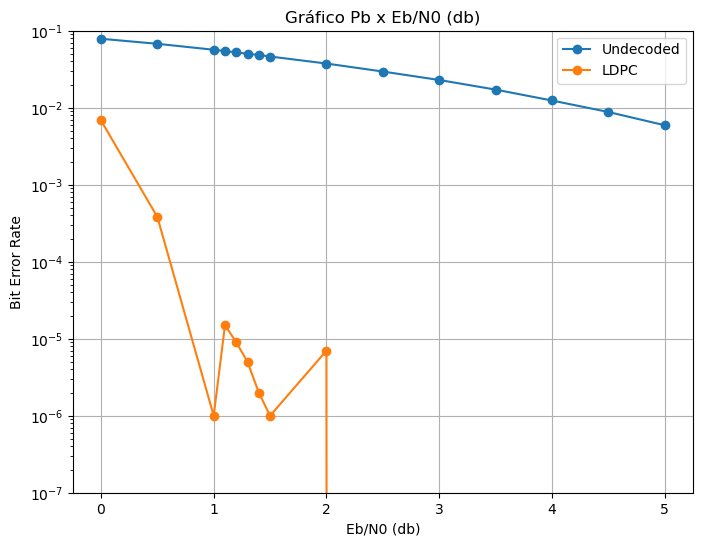

In [13]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(8, 6))

# Plotando os dados
plt.plot(dbs, undecodedErros, marker='o', label='Undecoded')
plt.plot(dbs, codedErros, marker='o', label='LDPC')
plt.yscale("log") 

# Configurando o título e os rótulos dos eixos
plt.title('Gráfico Pb x Eb/N0 (db)')
plt.xlabel('Eb/N0 (db)')
plt.ylabel('Bit Error Rate')

# Adicionando a legenda
plt.legend()

plt.ylim([0.0000001, 0.1])

# Exibindo o gráfico
plt.grid(True)
plt.show()

#### Maior Valor de E0/N0 que da erro menor que 10^(-4)

Nota-se que o valor deve estar entre 1 e 1.5

In [9]:
s = 10000
dbs = [1.09, 1.1, 1.11, 1.12]
for db in dbs:
    canalGauss = CanalGauss(10**(db/10))
    undErr = 0
    decErr = 0
    for k in range(s):
        v = [0]*n
        r = canalGauss.canal(v)
        L = canalGauss.LLR(r)
        o = canalGauss.beliefPropagation(L, ldpc.VNodes, ldpc.CNodes)
        decErr += sum(o)    
    
    print("db: ", db, "erro: ", decErr/(n*s))

db:  1.09 erro:  0.000105
db:  1.1 erro:  8.24e-05
db:  1.11 erro:  7.31e-05
db:  1.12 erro:  7.63e-05
